In [1]:
import numpy as np
np.random.seed(0)

import matplotlib
matplotlib.use("svg")
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score, log_loss)
from sklearn.model_selection import train_test_split

In [2]:
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=2)

train_samples = 100  # наблюдения для обучения моделей

X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

# создаем классификаторы
lr = LogisticRegression()
gnb = GaussianNB()
svc = LinearSVC(C=1.0)
rfc = RandomForestClassifier(n_estimators=100)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


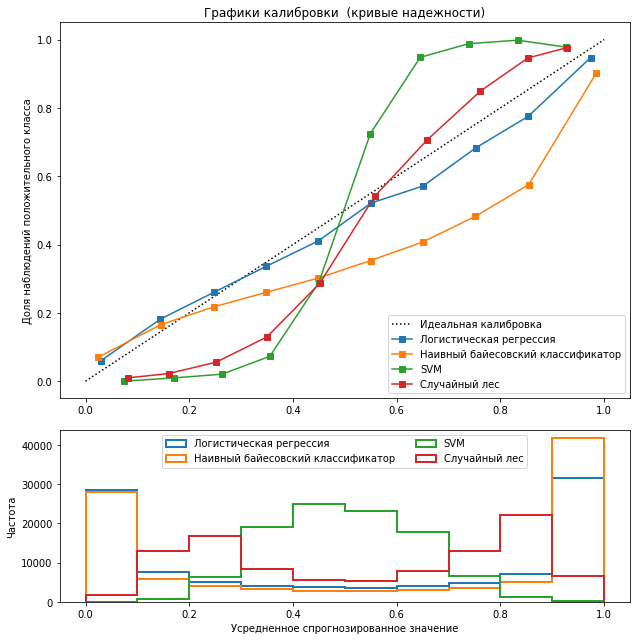

In [3]:
plt.figure(figsize=(9, 9))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
ax2 = plt.subplot2grid((3, 1), (2, 0))

ax1.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")
for clf, name in [(lr, 'Логистическая регрессия'),
                  (gnb, 'Наивный байесовский классификатор'),
                  (svc, 'SVM'),
                  (rfc, 'Случайный лес')]:
    clf.fit(X_train, y_train)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(X_test)[:, 1]
    else:  # используем решающую функцию
        prob_pos = clf.decision_function(X_test)
        prob_pos = \
            (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, prob_pos, n_bins=10)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="%s" % (name, ))

    ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
             histtype="step", lw=2)

ax1.set_ylabel("Доля наблюдений положительного класса")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('Графики калибровки  (кривые надежности)')

ax2.set_xlabel("Усредненное спрогнозированное значение")
ax2.set_ylabel("Частота")
ax2.legend(loc="upper center", ncol=2)

plt.tight_layout()

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


Text(0.5, 1.0, 'Данные')

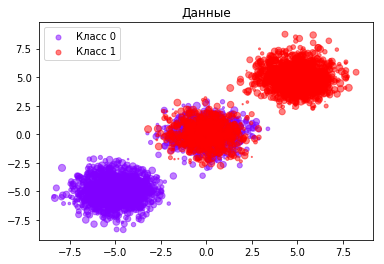

In [4]:
n_samples = 50000
n_bins = 3  # используем 3 бина для калибровочной кривой, поскольку у нас здесь 3 кластера

# Генерируем 3 облака данных с 2 классами, при этом второе облако
# содержит половину наблюдений положительного класса, половину
# наблюдений отрицательного класса. Поэтому вероятности в этом
# облаке равны 0,5

centers = [(-5, -5), (0, 0), (5, 5)]
X, y = datasets.make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                           centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# разбаваем на обучение и тест для калибровки
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50, c=color, alpha=0.5,
                label="Класс %s" % this_y)
plt.legend(loc="best")
plt.title("Данные")

In [5]:
# Гауссовский наивный байесовский классификатор без калибровки
clf = GaussianNB()
clf.fit(X_train, y_train)
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Гауссовский наивный байесовский классификатор с изотонической калибровкой
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Гауссовский наивный байесовский классификатор с сигмоидной калибровкой
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Оценки Бриера: (чем меньше, тем лучше)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sw_test)
print("Без калибровки: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sw_test)
print("С изотонической калибровкой: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sw_test)
print("С сигмоидной калибровкой: %1.3f" % clf_sigmoid_score)

Оценки Бриера: (чем меньше, тем лучше)
Без калибровки: 0.104
С изотонической калибровкой: 0.084
С сигмоидной калибровкой: 0.109


Text(0.5, 1.0, 'Вероятности гауссовского наивного байесовского классификатора')

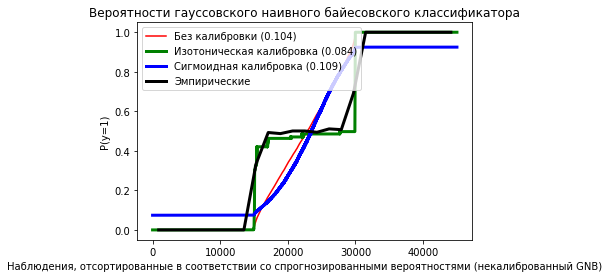

In [6]:
plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='Без калибровки (%1.3f)' % clf_score)
plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Изотоническая калибровка (%1.3f)' % clf_isotonic_score)
plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Сигмоидная калибровка (%1.3f)' % clf_sigmoid_score)
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Эмпирические')
plt.ylim([-0.05, 1.05])
plt.xlabel("Наблюдения, отсортированные в соответствии со спрогнозированными вероятностями"
           " (некалиброванный GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Вероятности гауссовского наивного байесовского классификатора")

In [7]:
# Создаем набор для задачи классификации с большим количеством избыточных переменных
# и несколькими информативными признаками
X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)

In [8]:
def plot_calibration_curve(est, name, fig_index):
    """Рисует калибровочную кривую. """
    # Модель изотонической калибровки
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Модель сигмоидной калибровки
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Логическая регрессия без калибровки в качестве исходной модели
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")
    for clf, name in [(lr, 'Логистическая регрессия'),
                      (est, name),
                      (isotonic, name + ' + Изотоническая'),
                      (sigmoid, name + ' + Сигмоидная')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # используем решающую функцию
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tОценка Бриера: %1.3f" % (clf_score))
        print("\tТочность: %1.3f" % precision_score(y_test, y_pred))
        print("\tПолнота: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Доля наблюдений положительного класса")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Графики калибровки (кривые надежности)')

    ax2.set_xlabel("Усредненное спрогнозированное значение")
    ax2.set_ylabel("Частота")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

Логистическая регрессия:
	Оценка Бриера: 0.099
	Точность: 0.872
	Полнота: 0.851
	F1: 0.862

SVC:
	Оценка Бриера: 0.163
	Точность: 0.872
	Полнота: 0.852
	F1: 0.862



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC + Изотоническая:
	Оценка Бриера: 0.100
	Точность: 0.853
	Полнота: 0.878
	F1: 0.865

SVC + Сигмоидная:
	Оценка Бриера: 0.099
	Точность: 0.874
	Полнота: 0.849
	F1: 0.861



/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


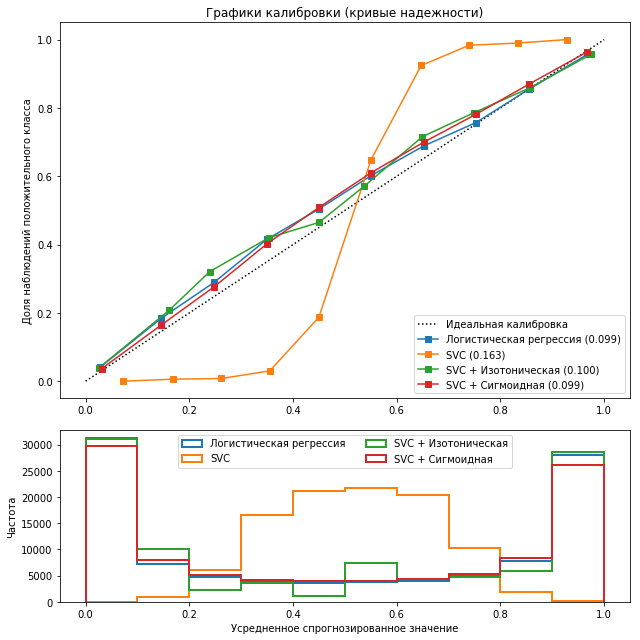

In [9]:
# Рисуем калибровочную кривую для линейного SVM
plot_calibration_curve(LinearSVC(), "SVC", 2)

Логистическая регрессия:
	Оценка Бриера: 0.099
	Точность: 0.872
	Полнота: 0.851
	F1: 0.862

Наивный байесовский классификатор:
	Оценка Бриера: 0.118
	Точность: 0.857
	Полнота: 0.876
	F1: 0.867

Наивный байесовский классификатор + Изотоническая:
	Оценка Бриера: 0.098
	Точность: 0.883
	Полнота: 0.836
	F1: 0.859

Наивный байесовский классификатор + Сигмоидная:
	Оценка Бриера: 0.109
	Точность: 0.861
	Полнота: 0.871
	F1: 0.866



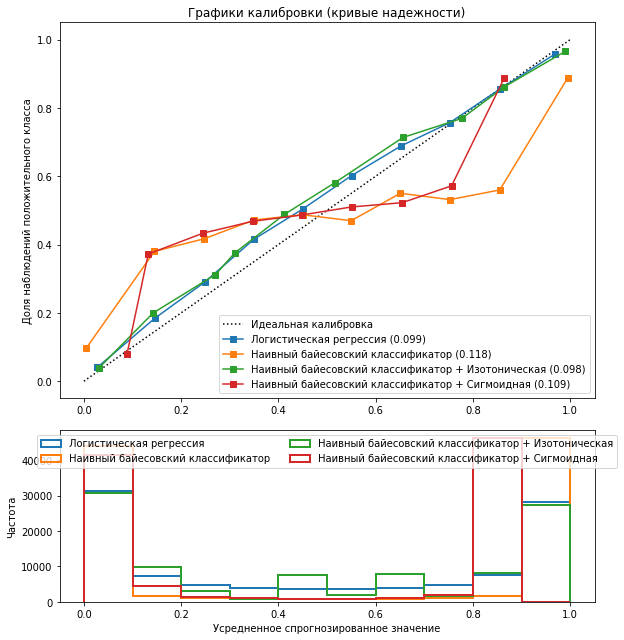

In [10]:
# Рисуем калибровочную кривую для наивного байесовского классификатора
plot_calibration_curve(GaussianNB(), "Наивный байесовский классификатор", 1)

In [11]:
np.random.seed(0)

# Генерируем данные
X, y = datasets.make_blobs(n_samples=1000, n_features=2, random_state=42,
                           cluster_std=5.0)
X_train, y_train = X[:600], y[:600]
X_valid, y_valid = X[600:800], y[600:800]
X_train_valid, y_train_valid = X[:800], y[:800]
X_test, y_test = X[800:], y[800:]

In [12]:
# Обучаем некалиброванный случайный лес деревьев классификации на объединенных
# обучающих и проверочных данных и оцениваем на тестовых данных 
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train_valid, y_train_valid)
clf_probs = clf.predict_proba(X_test)
score = log_loss(y_test, clf_probs)

# Обучаем случайный лес деревьев классификации, калибруем
# на проверочных данных и оцениваем на тестовых данных 
clf = RandomForestClassifier(n_estimators=25)
clf.fit(X_train, y_train)
clf_probs = clf.predict_proba(X_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(X_valid, y_valid)
sig_clf_probs = sig_clf.predict_proba(X_test)
sig_score = log_loss(y_test, sig_clf_probs)

/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


Функция потерь для
 * некалиброванного классификатора, обученного на 800 наблюдениях: 1.280 
 * классификатора, обученного на 600 наблюдениях и откалиброванного на 200 наблюдениях: 0.534


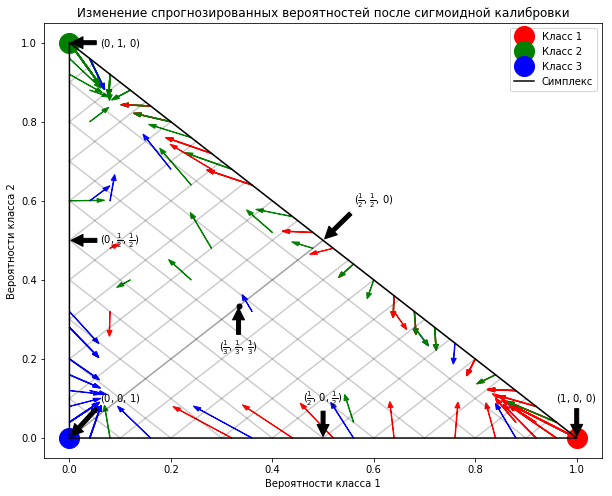

In [13]:
# Иллюстрирум изменения спрогнозированных вероятностей с помощью стрелок
plt.figure(0, figsize=(10, 8))
colors = ["r", "g", "b"]
for i in range(clf_probs.shape[0]):
    plt.arrow(clf_probs[i, 0], clf_probs[i, 1],
              sig_clf_probs[i, 0] - clf_probs[i, 0],
              sig_clf_probs[i, 1] - clf_probs[i, 1],
              color=colors[y_test[i]], head_width=1e-2)

# Отображаем идеальные прогнозы
plt.plot([1.0], [0.0], 'ro', ms=20, label="Класс 1")
plt.plot([0.0], [1.0], 'go', ms=20, label="Класс 2")
plt.plot([0.0], [0.0], 'bo', ms=20, label="Класс 3")

# Отображаем границы единичного симплекса
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Симплекс")

# Аннотируем точки
plt.annotate(r'($\frac{1}{3}$, $\frac{1}{3}$, $\frac{1}{3}$)',
             xy=(1.0/3, 1.0/3), xytext=(1.0/3, .23), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.plot([1.0/3], [1.0/3], 'ko', ms=5)
plt.annotate(r'($\frac{1}{2}$, $0$, $\frac{1}{2}$)',
             xy=(.5, .0), xytext=(.5, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $\frac{1}{2}$, $\frac{1}{2}$)',
             xy=(.0, .5), xytext=(.1, .5), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($\frac{1}{2}$, $\frac{1}{2}$, $0$)',
             xy=(.5, .5), xytext=(.6, .6), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $0$, $1$)',
             xy=(0, 0), xytext=(.1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($1$, $0$, $0$)',
             xy=(1, 0), xytext=(1, .1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
plt.annotate(r'($0$, $1$, $0$)',
             xy=(0, 1), xytext=(.1, 1), xycoords='data',
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='center', verticalalignment='center')
# Добавляем сетку
plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Изменение спрогнозированных вероятностей после сигмоидной калибровки")
plt.xlabel("Вероятности класса 1")
plt.ylabel("Вероятности класса 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.legend(loc="best")

print("Функция потерь для")
print(" * некалиброванного классификатора, обученного на 800 наблюдениях: %.3f "
      % score)
print(" * классификатора, обученного на 600 наблюдениях и откалиброванного на "
      "200 наблюдениях: %.3f" % sig_score)

(-0.05, 1.05)

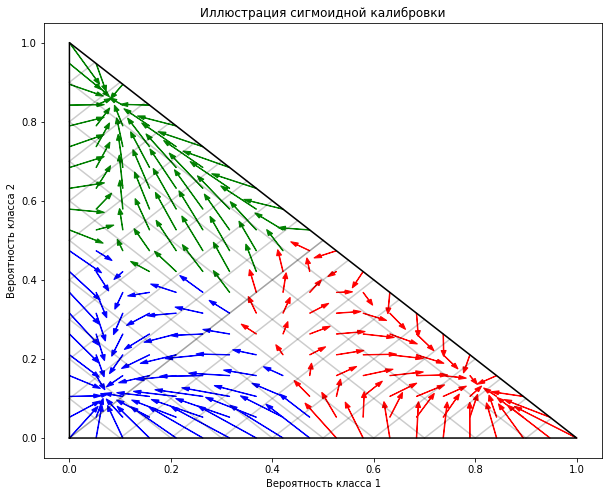

In [14]:
# Выводим калибратор
plt.figure(1, figsize=(10, 8))
# Создаем сетку для 2-симплекса
p1d = np.linspace(0, 1, 20)
p0, p1 = np.meshgrid(p1d, p1d)
p2 = 1 - p0 - p1
p = np.c_[p0.ravel(), p1.ravel(), p2.ravel()]
p = p[p[:, 2] >= 0]

calibrated_classifier = sig_clf.calibrated_classifiers_[0]
prediction = np.vstack([calibrator.predict(this_p)
                        for calibrator, this_p in
                        zip(calibrated_classifier.calibrators_, p.T)]).T
prediction /= prediction.sum(axis=1)[:, None]

# Показываем изменения
for i in range(prediction.shape[0]):
    plt.arrow(p[i, 0], p[i, 1],
              prediction[i, 0] - p[i, 0], prediction[i, 1] - p[i, 1],
              head_width=1e-2, color=colors[np.argmax(p[i])])
# Выводим границы единичного симплекса
plt.plot([0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 1.0, 0.0], 'k', label="Simplex")

plt.grid("off")
for x in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.plot([0, x], [x, 0], 'k', alpha=0.2)
    plt.plot([0, 0 + (1-x)/2], [x, x + (1-x)/2], 'k', alpha=0.2)
    plt.plot([x, x + (1-x)/2], [0, 0 + (1-x)/2], 'k', alpha=0.2)

plt.title("Иллюстрация сигмоидной калибровки")
plt.xlabel("Вероятность класса 1")
plt.ylabel("Вероятность класса 2")
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)